In [1]:
import os, sys

recsys_cf = os.environ.get("RECSYS_STORY")
sys.path.append(recsys_cf)
os.chdir(recsys_cf)

from lib.tools import *

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

# Preproc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score,  f1_score

# Model
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [3]:
sp = spark(**SPARK_CONFIG)
hive = sp.sql

In [4]:
train_sdf = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET_TRAIN_POS, hive)
val_sdf = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET_VAL, hive)
test_sdf = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_TEST, hive)

In [5]:
%%time
train = train_sdf.toPandas()
val = val_sdf.toPandas()
test = test_sdf.toPandas()

CPU times: user 45.8 s, sys: 3.76 s, total: 49.6 s
Wall time: 1min 13s


In [6]:
COL_USER = "user_id"
COL_ITEM = "item_id"
COL_TIMESTAMP = "timestamp"
COL_RATING = "rating"
COL_PREDICTION = "prediction"

###### base model

In [7]:
header = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING,
    "implicitPrefs": True
}

In [8]:
als = ALS(
    **header
)

In [9]:
%%time
model = als.fit(train_sdf)

CPU times: user 21.2 ms, sys: 7.12 ms, total: 28.3 ms
Wall time: 24.3 s


In [10]:
%%time
pred = model.transform(val_sdf).toPandas()

CPU times: user 146 ms, sys: 6.86 ms, total: 153 ms
Wall time: 4.71 s


In [11]:
from pyspark.ml import Pipeline, Transformer

class CastPrediction(Transformer):
    def __init__(self):
        super().__init__()
    
    def transform(self, dataset, params=None):
        return dataset.withColumn("prediction", 
                                  f.col("prediction").cast(stypes.DoubleType()))
    
cast_prediction = CastPrediction()

In [12]:
pipeline = Pipeline(stages=[als, cast_prediction])

In [13]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="rating")

In [14]:
model = pipeline.fit(train_sdf)

In [15]:
evaluator.evaluate(model.transform(val_sdf))

0.6668503678828096

добавим вызов объекта напрямую, а не через метод

In [16]:
BinaryClassificationEvaluator.__call__ = lambda self, dataset: self.evaluate(dataset) 

In [17]:
model = pipeline.fit(train_sdf)

In [18]:
evaluator(model.transform(val_sdf))

0.6668503678828098

###### Подбор параметров

In [19]:
target_metric = evaluator
metrics = {
    "roc_auc" : evaluator
}

In [20]:
def grid_search(grid):

    history_params = []
    history_scores = { name: [] for name in metrics.keys()}

    best_score = 0
    best_params = None
    best_model = None

    for params in tqdm_notebook(ParameterGrid(grid)):    
        # Fitting
        als = ALS(
            **header,
            **params
        )
        
        pipeline = Pipeline(stages=[als, cast_prediction])
        model = pipeline.fit(train_sdf)

        # Prediction
        pred = model.transform(val_sdf)
        
        # Target scoring
        score = target_metric(pred)
        if score > best_score:
            best_score = score
            best_params = params
            best_model = model

        # History
        if metrics is not None:
            for name, metric in metrics.items():
                history_scores[name].append(metric(pred))
        history_params.append(params)
    
    results = [
        best_score,
        best_params,
        best_model,
        history_params,
        history_scores
    ]
    
    return results

###### Одномерный перебор 

rank


Best score: 0.6668503678828098
Best param: {'rank': 10}


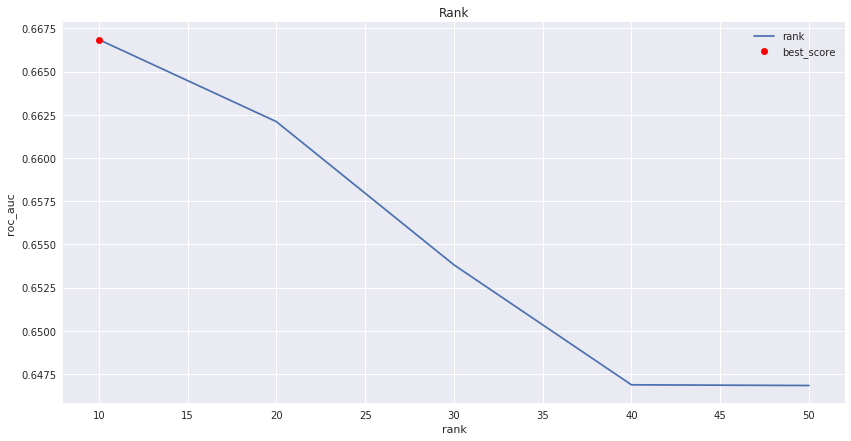

CPU times: user 597 ms, sys: 2.39 s, total: 2.99 s
Wall time: 4min 54s


In [21]:
%%time
grid = {
    "rank": np.arange(10, 51, 10)
}

best_score, best_params, best_model, history_params, history_scores = grid_search(grid)

print("Best score: {}".format(best_score))
print("Best param: {}".format(best_params))

plt.figure(figsize=(14, 7))

plt.plot(grid["rank"], history_scores["roc_auc"], label="rank")
plt.plot(best_params["rank"], best_score, "or", label="best_score")

plt.title("Rank")
plt.xlabel("rank")
plt.ylabel("roc_auc")
plt.legend()
plt.show()

In [22]:
{key: [value] for key, value in best_params.items()}

{'rank': [10]}

max_iter


Best score: 0.673086503146225
Best param: {'maxIter': 6, 'rank': 10}


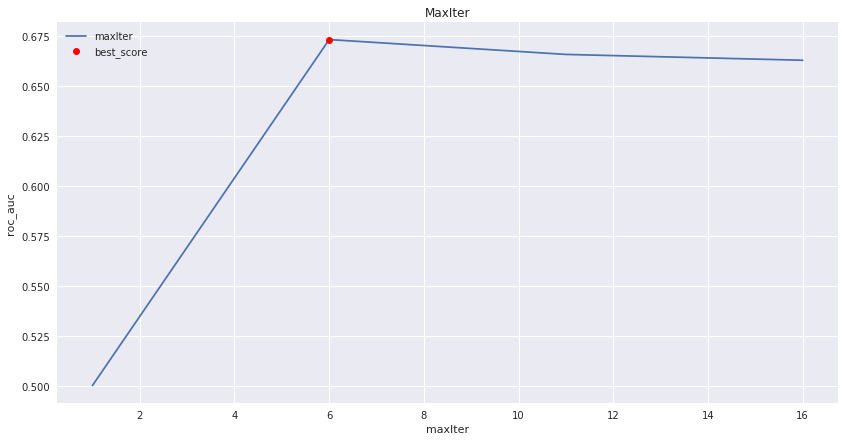

CPU times: user 483 ms, sys: 694 ms, total: 1.18 s
Wall time: 1min 57s


In [23]:
%%time
grid = {
    **{key: [value] for key, value in best_params.items()},
    "maxIter": np.arange(1, 21, 5)
}

best_score, best_params, best_model, history_params, history_scores = grid_search(grid)

print("Best score: {}".format(best_score))
print("Best param: {}".format(best_params))

plt.figure(figsize=(14, 7))

plt.plot(grid["maxIter"], history_scores["roc_auc"], label="maxIter")
plt.plot(best_params["maxIter"], best_score, "or", label="best_score")

plt.title("MaxIter")
plt.xlabel("maxIter")
plt.ylabel("roc_auc")
plt.legend()
plt.show()

In [24]:
{key: [value] for key, value in best_params.items()}

{'maxIter': [6], 'rank': [10]}

reg param


Best score: 0.6980240397236739
Best param: {'regParam': 1.0, 'maxIter': 6, 'rank': 10}


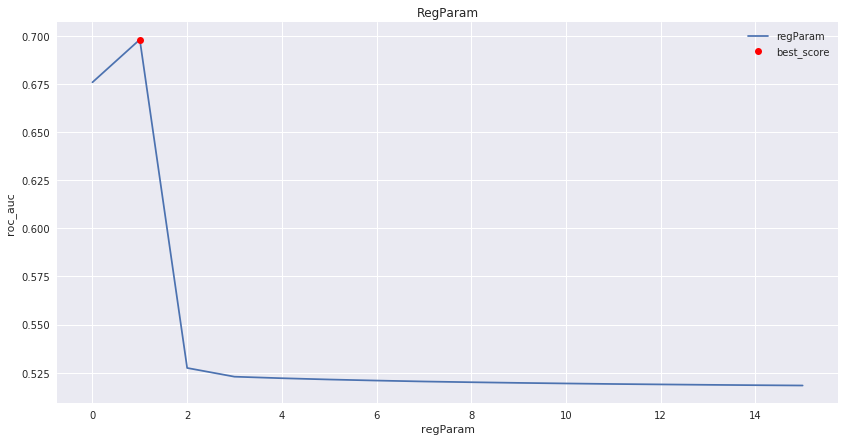

CPU times: user 816 ms, sys: 916 ms, total: 1.73 s
Wall time: 6min 31s


In [25]:
%%time
grid = {
    **{key: [value] for key, value in best_params.items()},
    "regParam": np.arange(0, 15.1, 1)
}

best_score, best_params, best_model, history_params, history_scores = grid_search(grid)

print("Best score: {}".format(best_score))
print("Best param: {}".format(best_params))

plt.figure(figsize=(14, 7))

plt.plot(grid["regParam"], history_scores["roc_auc"], label="regParam")
plt.plot(best_params["regParam"], best_score, "or", label="best_score")

plt.title("RegParam")
plt.xlabel("regParam")
plt.ylabel("roc_auc")
plt.legend()
plt.show()

In [26]:
{key: [value] for key, value in best_params.items()}

{'maxIter': [6], 'rank': [10], 'regParam': [1.0]}

alpha


Best score: 0.698024039723674
Best param: {'regParam': 1.0, 'maxIter': 6, 'alpha': 1, 'rank': 10}


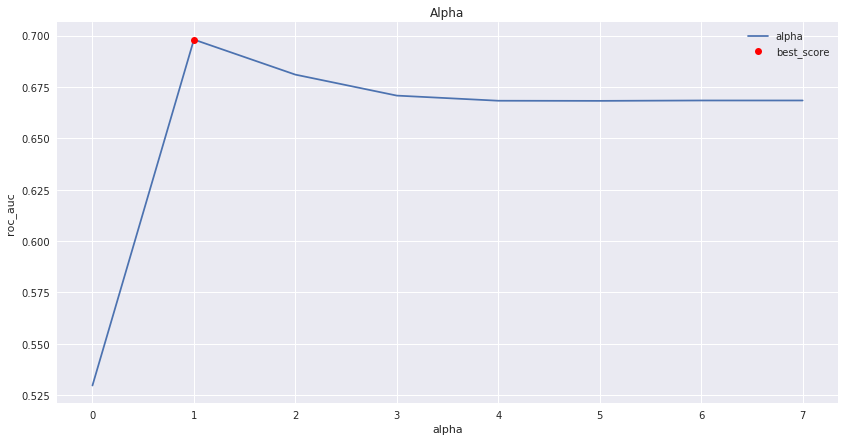

CPU times: user 618 ms, sys: 762 ms, total: 1.38 s
Wall time: 3min 9s


In [27]:
%%time
grid = {
    **{key: [value] for key, value in best_params.items()},
    "alpha": np.arange(0, 8, 1)
}

best_score, best_params, best_model, history_params, history_scores = grid_search(grid)

print("Best score: {}".format(best_score))
print("Best param: {}".format(best_params))

plt.figure(figsize=(14, 7))

plt.plot(grid["alpha"], history_scores["roc_auc"], label="alpha")
plt.plot(best_params["alpha"], best_score, "or", label="best_score")

plt.title("Alpha")
plt.xlabel("alpha")
plt.ylabel("roc_auc")
plt.legend()
plt.show()

In [28]:
{key: [value] for key, value in best_params.items()}

{'alpha': [1], 'maxIter': [6], 'rank': [10], 'regParam': [1.0]}

nonnegative

In [29]:
%%time
grid = {
    **{key: [value] for key, value in best_params.items()},
    "nonnegative": [False, True]
}

best_score, best_params, best_model, history_params, history_scores = grid_search(grid)

print("Best score: {}".format(best_score))
print("Best param: {}".format(best_params))

for param, score in zip(grid["nonnegative"], history_scores["roc_auc"]):
    print("{}: {}".format(param, score))


Best score: 0.6980240397236742
Best param: {'nonnegative': False, 'maxIter': 6, 'alpha': 1, 'rank': 10, 'regParam': 1.0}
False: 0.6980240397236739
True: 0.6960749641544078
CPU times: user 79.8 ms, sys: 45.1 ms, total: 125 ms
Wall time: 54.2 s


In [30]:
{key: [value] for key, value in best_params.items()}

{'alpha': [1],
 'maxIter': [6],
 'nonnegative': [False],
 'rank': [10],
 'regParam': [1.0]}

###### Валидация лучшей модели 

In [31]:
%%time

als = ALS(
    **header,
    **best_params
)

best_model = als.fit(train_sdf)

pred = best_model.transform(val_sdf).toPandas()
pred["prediction"] = MinMaxScaler().fit_transform(pred[["prediction"]])

CPU times: user 136 ms, sys: 13.3 ms, total: 149 ms
Wall time: 17.4 s


In [32]:
def get_best_roc_threshold(pred):
    pred_cols = [pred["rating"], pred["prediction"]]
    
    fpr, tpr, thresholds_roc = roc_curve(*pred_cols)

    sensitivity = tpr
    specificity = 1 - fpr
    gmeans = np.sqrt(sensitivity * specificity)

    ix_gmean = np.argmax(gmeans)
    best_threshold_roc = thresholds_roc[ix_gmean]
    
    return best_threshold_roc
    
    
def print_metrics(pred):
    pred_cols = [pred["rating"], pred["prediction"]]
    
    best_threshold_roc = get_best_roc_threshold(pred)
    pred_crisp_cols = [pred.rating, pred.prediction > best_threshold_roc]
    
    print("ROC_AUC: {:.4f}".format(roc_auc_score(*pred_cols)))

    print("Precision: {:.4f}".format(precision_score(*pred_crisp_cols)))
    print("Recall: {:.4f}".format(recall_score(*pred_crisp_cols)))
    print("F1-score: {:.4f}".format(f1_score(*pred_crisp_cols)))

    tn, fp, fn, tp = confusion_matrix(*pred_crisp_cols).ravel()
    print("TP: {}, FP: {}".format(tp, fp))
    print("FN: {}, TN: {}".format(fn, tn))

    print("Log loss: {:.4f}".format(log_loss(*pred_cols)))

In [33]:
print_metrics(pred)

ROC_AUC: 0.6980
Precision: 0.1389
Recall: 0.7466
F1-score: 0.2342
TP: 1821, FP: 11292
FN: 618, TN: 13673
Log loss: 0.3662
